In [3]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import measure
from tqdm import tqdm
import random
import copy

import SimpleITK as sitk
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import os

In [2]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [3]:
dataRoot ="E:/ENGINEERING PROJECTS/MINI1/VAMSI/datasets/The IQ-OTHNCCD lung cancer dataset/"

In [4]:
model = tf.keras.models.load_model(r"E:\ENGINEERING PROJECTS\MINI1\VAMSI\Unet\UNet_best_Model_checkpoint.keras", custom_objects={'dice_coef':dice_coef, 'dice_coef_loss':dice_coef_loss})
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coef])

E:\anaconda\lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 94 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [5]:
mfiles = os.listdir(dataRoot+"Malignant cases/")
random.shuffle(mfiles)
mfiles = mfiles[:30]
bfiles = os.listdir(dataRoot+"Bengin cases/")
random.shuffle(bfiles)
bfiles = bfiles[:30]
nfiles = os.listdir(dataRoot+"Normal cases/")
random.shuffle(nfiles)
nfiles = nfiles[:30]

In [6]:
def preprocess(img):
    if img.max()>255 or img.max()<1.5 or img.min()<0:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (512,512))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_improved = clahe.apply(img.astype(np.uint8))
    # img_improved = img.copy()
    centeral_area = img[100:400, 100:400]
    kmeans = KMeans(n_clusters=2).fit(np.reshape(centeral_area, [np.prod(centeral_area.shape), 1]))
    centroids = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centroids)
    ret, lung_roi = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY_INV)
    lung_roi = cv2.erode(lung_roi, kernel=np.ones([4,4]))
    lung_roi = cv2.dilate(lung_roi, kernel=np.ones([13,13]))
    lung_roi = cv2.erode(lung_roi, kernel=np.ones([8,8]))

    labels = measure.label(lung_roi)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0] < 500 and B[3]-B[1] < 490 and B[0] > 17 and B[2] < 495:
            good_labels.append(prop.label)
    lung_roi_mask = np.zeros_like(labels)
    for N in good_labels:
        lung_roi_mask = lung_roi_mask + np.where(labels == N, 1, 0)

    contours, hirearchy = cv2.findContours(lung_roi_mask,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    external_contours = np.zeros(lung_roi_mask.shape)
    for i in range(len(contours)):
        if hirearchy[0][i][3] == -1:  #External Contours
            area = cv2.contourArea(contours[i])
            if area>518.0:
                cv2.drawContours(external_contours,contours,i,(1,1,1),-1)
    external_contours = cv2.dilate(external_contours, kernel=np.ones([4,4]))

    external_contours = cv2.bitwise_not(external_contours.astype(np.uint8))
    external_contours = cv2.erode(external_contours, kernel=np.ones((7,7)))
    external_contours = cv2.bitwise_not(external_contours)
    external_contours = cv2.dilate(external_contours, kernel=np.ones((12,12)))
    external_contours = cv2.erode(external_contours, kernel=np.ones((12,12)))

    contours, hirearchy = cv2.findContours(external_contours,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    external_contours2 = np.zeros(external_contours.shape)
    for i in range(len(contours)):
        if hirearchy[0][i][3] == -1:  #External Contours
            area = cv2.contourArea(contours[i])
            if area>518.0:
                cv2.drawContours(external_contours2,contours,i,(1,1,1),-1)

    img_improved = img_improved.astype(np.uint8)
    external_contours2 = external_contours2.astype(np.uint8)
    extracted_lungs = cv2.bitwise_and(img_improved, img_improved, mask=external_contours2)

    return ((extracted_lungs-127.0)/127.0).astype(np.float32)

In [7]:
def display(imgs,mask):
    j = 1
    for im,mk in zip(imgs,mask):
      plt.figure(figsize=(20,300))
      plt.subplot(50,3,j)
      plt.imshow(np.squeeze(im), cmap="gray")
      plt.subplot(50,3,j+1)
      plt.imshow(np.squeeze(mk), cmap="gray")
      plt.subplot(50,3,j+2)
      plt.imshow(cv2.addWeighted(np.squeeze(im), .5, np.squeeze(mk), .5, 0), cmap="gray")
      j += 3
        


In [17]:
import os
import cv2

output_folder = r"E:\ENGINEERING PROJECTS\MINI1\VAMSI\Unet\outputs\test2"

def save_images(imgs, mask):
    for j, (im, mk) in enumerate(zip(imgs, mask), start=1):
        output_subfolder = os.path.join(output_folder, f"outputs_{j}")
        os.makedirs(output_subfolder, exist_ok=True)
       
        plt.figure(figsize=(20, 10))
        
        # Save input image
        input_path = os.path.join(output_subfolder, f"input_{j}.jpg")
        plt.imshow(np.squeeze(im), cmap="gray")
        plt.axis('off')  # Turn off axes
        plt.savefig(input_path, bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the figure to avoid displaying
        
        # Save prediction mask
        prediction_path = os.path.join(output_subfolder, f"prediction_{j}.jpg")
        plt.imshow(np.squeeze(mk), cmap="gray")
        plt.axis('off')  # Turn off axes
        plt.savefig(prediction_path, bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the figure to avoid displaying
        
        # Save overlay image
        overlay_path = os.path.join(output_subfolder, f"overlay_{j}.jpg")
        overlay = cv2.addWeighted(np.squeeze(im), .5, np.squeeze(mk), .5, 0)
        plt.imshow(overlay, cmap="gray")
        plt.axis('off')  # Turn off axes
        plt.savefig(overlay_path, bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the figure to avoid displaying


In [9]:
def display2(imgs, titles=None, cmap="bone"):
    n = len(list(imgs))
    r = n//3 if n%3==0 else (n//3)+1
    plt.figure(figsize=(25,int(8*r)))
    for i,img in enumerate(imgs):
        plt.subplot(r,3,i+1)
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(img, cmap=cmap)

In [10]:
def display_test(img, cmap='bone'):
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap=cmap)

In [11]:
originals = []
mimgs = []
image_path = r"E:\ENGINEERING PROJECTS\MINI1\VAMSI\datasets\The IQ-OTHNCCD lung cancer dataset\Malignant cases\Malignant case (52).jpg"
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img = cv2.imread(image_path, 0)
resized_img = cv2.resize(img, (512, 512))
enhanced_img = clahe.apply(resized_img.astype(np.uint8))
originals.append(enhanced_img)

preprocessed_img = preprocess(img)
mimgs.append(preprocessed_img)
mi = np.array(mimgs)
mi_reshaped = np.reshape(mi, (len(mi), 512, 512, 1))
pred = model.predict(mi_reshaped)
pred_binary = (pred >= 0.5) * 255  # Binarize predictions using a threshold of 0.5
pred_binary = pred_binary.astype(np.uint8)
pred_list = list(pred_binary)
mpred = [np.squeeze(mask) for mask in pred_list]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


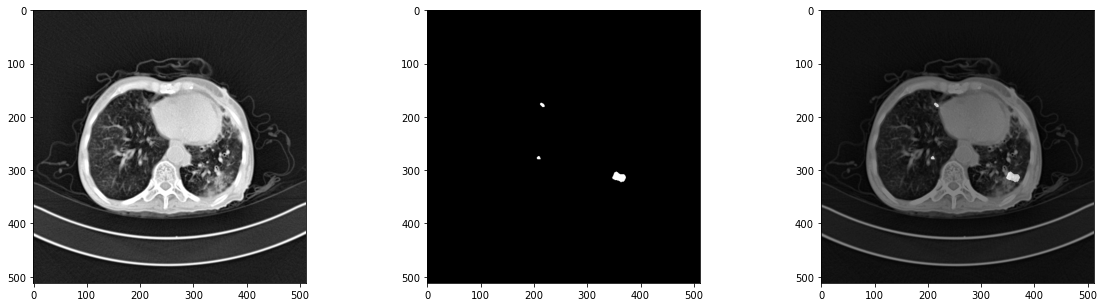

In [15]:
display(originals,mpred)

In [18]:
save_images(originals,mpred)

In [20]:
bboxes = []
for mask in mpred:
    mask = cv2.dilate(mask, kernel=np.ones((5,5)))
    labels = measure.label(mask)
    regions = measure.regionprops(labels)
    bb = []
    for prop in regions:
        B = prop.bbox
        bb.append((( max(0, B[1]-10), max(0, B[0]-10) ),( min(B[3]+10, 512), min(B[2]+10, 512) )))    # ((x1,y1),(x2,y2))
    bboxes.append(bb)

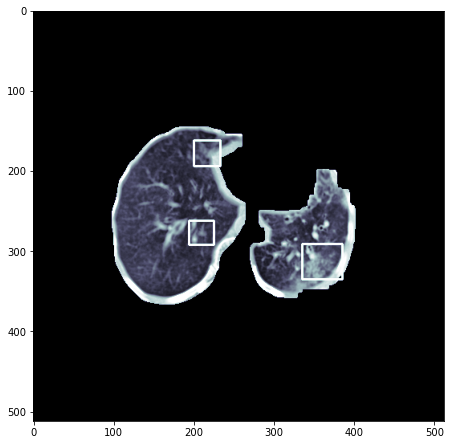

In [21]:
o = copy.deepcopy(mimgs)
for i,(img,boxes) in enumerate(zip(o,bboxes)):
    for rect in boxes:
        cv2.rectangle(img, rect[0], rect[1], (1), 2)
display2(o)

In [24]:
o2 = copy.deepcopy(originals)
final_boxes = []
for i,(img,bbox) in enumerate(zip(o2, bboxes)):
    img_boxes = []
    for box in bbox:
        x1 = box[0][0]
        y1 = box[0][1]
        x2 = box[1][0]
        y2 = box[1][1]
        if abs(x1-x2) <=50 or abs(y1-y2)<=50:
            x = (x1+x2)//2
            y = (y1+y2)//2
            x1 = max(x-25, 0)
            x2 = min(x+25, 512)
            y1 = max(y-25, 0)
            y2 = min(y+25, 512)
            imgbox = img[y1:y2,x1:x2]
            img_boxes.append(imgbox)
        else:
            imgbox = img[y1:y2,x1:x2]
            img_boxes.append(imgbox)
    final_boxes.append(img_boxes)

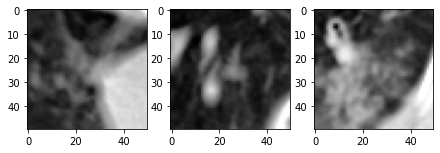

In [25]:
plt.figure(figsize=(15,15))
for i,img in enumerate(final_boxes[0]):
    plt.subplot(1,6,i+1)
    plt.imshow(img, cmap="gray")

KeyError: 'x'

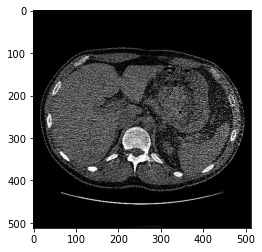

In [2]:
def read_mhd_image(mhd_path):
    # Read the image using SimpleITK
    itkimage = sitk.ReadImage(mhd_path)
    numpy_image = sitk.GetArrayFromImage(itkimage)
    return numpy_image

def convert_to_jpg(numpy_image, output_path):
    # Convert numpy array to an image
    image = Image.fromarray((numpy_image * 255).astype(np.uint8))  # Scale to 0-255 and convert to uint8
    image = image.convert('RGB')
    image.save(output_path)

def draw_bounding_boxes(image_path, annotations, output_path):
    # Load the image
    image = plt.imread(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap='gray')
    
    # Draw each bounding box based on the annotations
    for index, row in annotations.iterrows():
        # Calculate bounding box
        radius = row['diameter_mm'] / 2
        x = row['coordX'] - radius
        y = row['coordY'] - radius
        rect = patches.Rectangle((x, y), 2*radius, 2*radius, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    # Save the image with bounding boxes
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def main(mhd_file, csv_file, output_folder, series_uid):
    os.makedirs(output_folder, exist_ok=True)
    # Read .mhd file
    img = read_mhd_image(mhd_file)
    
    # Convert to JPG (processing first slice as example)
    img = img[0] if img.ndim > 2 else img  # Use first slice if 3D
    jpg_path = os.path.join(output_folder, f'{series_uid}.jpg')
    convert_to_jpg(img, jpg_path)

    # Read annotations and filter for current seriesuid
    annotations = pd.read_csv(csv_file)
    annotations = annotations[annotations['seriesuid'] == series_uid]
    
    # Draw bounding boxes
    output_with_boxes = os.path.join(output_folder, f'{series_uid}_with_boxes.jpg')
    draw_bounding_boxes(jpg_path, annotations, output_with_boxes)
    print("Images saved:", jpg_path, output_with_boxes)

if __name__ == '__main__':
    mhd_file = 'path_to_your.mhd'
    csv_file = 'path_to_your_annotations.csv'
    output_folder = 'output_directory'
    series_uid = 'specific_series_uid_from_your_data'
    main(mhd_file, csv_file, output_folder, series_uid)


if __name__ == '__main__':
    mhd_file = r"E:\ENGINEERING PROJECTS\MINI1\VAMSI\datasets\LUNA16\subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd"
    csv_file = r"E:\ENGINEERING PROJECTS\MINI1\VAMSI\datasets\LUNA16\annotations.csv"
    output_folder = r"E:\ENGINEERING PROJECTS\MINI1\VAMSI\Unet"
    main(mhd_file, csv_file, output_folder)
